### Hyperparameter Tuning

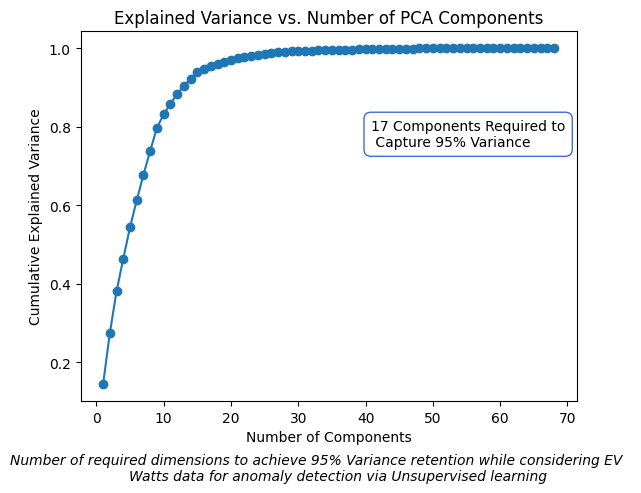

Sensitivity Analysis Finished in 0.5 minutes
Sensitivity Analysis Finished in 0.1 minutes


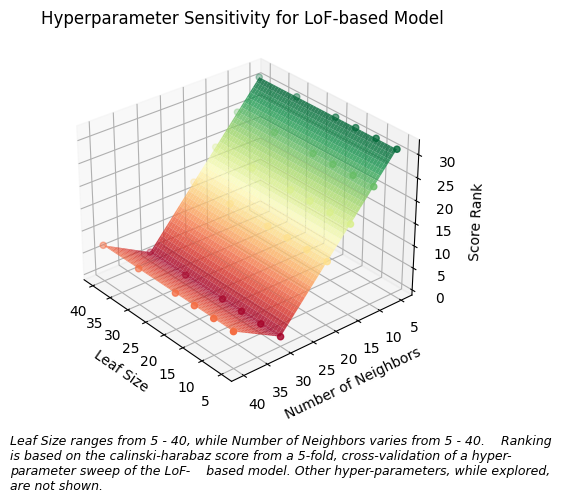

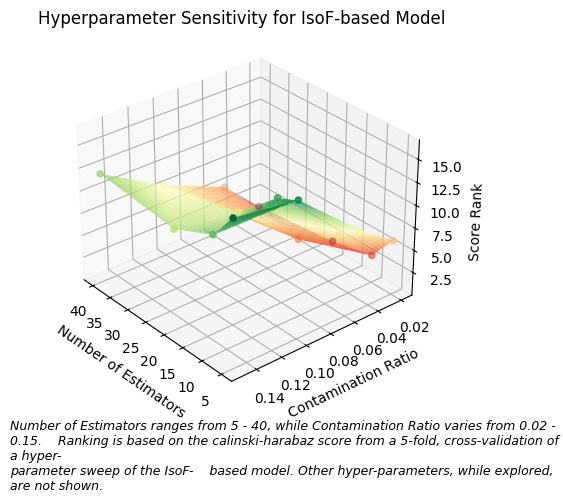

In [11]:
#Import general packages
import time
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

#model options: 
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM #very slow
from sklearn.neighbors import LocalOutlierFactor

#model eval packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import LocalOutlierFactor

#Import pyscripts 
import Unsupervised_Learning_V3


def lof_sensitivity_analysis(input_training_data, n_list = [5, 10, 20, 40], 
                             algorithm = ['ball_tree', 'kd_tree', 'brute'], 
                             leaf_size = [10, 30, 50],
                             p = [1,2]):
    
    """
    grid-search hyper-param tuning & sensitivty analysis for LoF model 
    
    INPUTS: 
    input_training data: a dataframe of the training data 
    n_list: the list of neighbor values (integers) to evaluate
    algorithm: the list of algorithms to use in the LoF (ball_tree, kd_tree, and/or brute) 
    leaf_size: the list of leaf numbers in the model (integer) 
    p: the distance measurement method (1 for manhattan, 2 for euclidean)
    
    OUTPUTS: 
    results: a pandas dataframe with the score for the different grid-search combinations
    """

    class LOF_grid_search(LocalOutlierFactor):
        """This class is used for hyper-parameter tuning of the LoF model for cluster analysis
        """
        def __init__(self, n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2):
            super().__init__(n_neighbors=n_neighbors, algorithm=algorithm, leaf_size=leaf_size, metric=metric, p=p)
    
        def fit(self, X, y=None):
            self.model = LocalOutlierFactor(
                n_neighbors=self.n_neighbors,
                algorithm=self.algorithm,
                leaf_size=self.leaf_size,
                metric=self.metric,
                p=self.p
            )
            self.model.fit(X)
            return self
    
        def score(self, X, y=None):
            y_pred = self.model.fit_predict(X)
            return calinski_harabasz_score(X, y_pred)
    
    
    param_grid = {
        'n_neighbors': n_list,
        'algorithm': algorithm,
        'leaf_size': leaf_size,
        'p': p  # Fixed parameter values to avoid 'p'
    }
    
    start = time.time()
    LOF_grid_search = LOF_grid_search()
    
    grid_search = GridSearchCV(estimator=LOF_grid_search, param_grid=param_grid, cv=5)
    grid_search.fit(input_training_data)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    #clock performance & return results 
    end = time.time() 
    print(f"Sensitivity Analysis Finished in {np.round((end - start)/60,1)} minutes")
    return results


def IsoF_sensitivity_analysis(input_training_data, n_estim = [5, 10, 20, 40], 
                             contam_ratio = [0.02, 0.05, 0.1, 0.15],
                             ):
    
    """
    grid-search hyper-param tuning & sensitivty analysis for LoF model 
    
    INPUTS: 
    input_training data: a dataframe of the training data 
    n_estim: the list of number of estimators to use
    contam_ratio: the ratios of contamination in the training data 
    
    OUTPUTS: 
    results: a pandas dataframe with the score for the different grid-search combinations
    """


    class IsoF_grid_search(IsolationForest):
        """This class is used for hyper-parameter tuning of the IsoF model for cluster analysis
        """
        def __init__(self, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False):
            super().__init__(n_estimators=n_estimators,contamination=contamination)
        
        def fit(self, X, y=None):
            self.model = IsolationForest(
                n_estimators = self.n_estimators,
                contamination=self.contamination,
            )
            self.model.fit(X)
            return self
        
        def score(self, X, y=None):
            y_pred = self.model.fit_predict(X)
            return calinski_harabasz_score(X, y_pred)

    
    param_grid = {
        'n_estimators': n_estim,
        'contamination': contam_ratio,
    }
    
    start = time.time()
    IsoF_grid_search = IsoF_grid_search()
    
    grid_search = GridSearchCV(estimator=IsoF_grid_search, param_grid=param_grid, cv=5)
    grid_search.fit(input_training_data)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    #clock performance & return results 
    end = time.time() 
    print(f"Sensitivity Analysis Finished in {np.round((end - start)/60,1)} minutes")
    return results        
    

def hyper_parameter_plotting(input_df, model_type, col_x, col_y, col_z, x_name=None, y_name=None, z_name =None, fig_rotation=140): 
    """This function creates a 3D plot showing the sensitivty analysis for a model score against two hyper parameters
    INPUTS: 
    input_df: a pandas dataframe for ploting score vs. hyper params
    model_type: the type of model being evaluated
    col_x: hyper-parameter 1 to display
    col_y: hyper-parameter 2 to display
    col_z: the scoring column
    x_name: the string to name/label X dimension
    y_name: the string to name/label Y dimension
    z_name: the string to name/label Z dimension
    fig_rotation: the azimuth rotation angle for the plot

    OUTPUTS: none. A plt 3d plot is displayed 
    """
    
    
    X = input_df[col_x]
    Y = input_df[col_y]
    Z = input_df[col_z]

    if x_name == None: 
        x_name = col_x
    if y_name == None: 
        y_name = col_y
    if z_name == None: 
        z_name = col_z
    
    #Grid for plot contours: 
    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((X, Y), Z, (xi, yi), method='linear')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    norm = plt.Normalize(Z.min(), Z.max())
    colors = plt.cm.RdYlGn(norm(Z))  # Using the 'RdYlGn' colormap
    
    #surface map: 
    surface = ax.plot_surface(xi, yi, zi, cmap='RdYlGn', alpha=0.8)
    
    # Create scatter plot
    scatter = ax.scatter(X, Y, Z, c=colors, marker='o')
    
    # Setting labels
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.set_title(f"Hyperparameter Sensitivity for {model_type}-based Model")
    
    ax.view_init(elev=30, azim=fig_rotation)  # Adjust these values to change the angle
    
    plot_subtext = (f"{x_name} ranges from {X.min()} - {X.max()}, while {y_name} varies from {Y.min()} - {Y.max()}.\
    Ranking is based on the calinski-harabaz score from a 5-fold, cross-validation of a hyper-\nparameter sweep of the {model_type}-\
    based model. Other hyper-parameters, while explored, are not shown.") 
    
    plt.figtext(
        0.15, -0.07, plot_subtext, wrap=True, horizontalalignment='left', fontsize=9, fontstyle='italic',
    )
    
    plt.show()


def hyper_parameter_pipe(num_sample=1000):
    
    #Get training data for hyper-param analysis
    pca_X_train, pca_X_test, y_train, y_test, pca_X, y = Unsupervised_Learning_V3.get_data_pipe(num_sample=num_sample)

    #Set LoF hyper params to grid-search evaluate
    neighbor_list = [5, 10, 15, 20, 30, 40]
    algorithm_list = ['ball_tree']
    leaf_list = [5, 10, 15, 20, 30, 40]
    p_list = [1]

    #Set IsoF hyper params to grid-search evaluate
    n_estim_list = [5, 10, 20, 40]
    contam_ratio_list = [0.02, 0.05, 0.1, 0.15]
    
    #start clock (to help with HPC timing)
    start = time.time() 

    #run evaluation
    df_lof = lof_sensitivity_analysis(pca_X_train, n_list = neighbor_list, algorithm = algorithm_list, 
                                              leaf_size = leaf_list, p = p_list)

    df_isoF = IsoF_sensitivity_analysis(pca_X_train, n_estim = n_estim_list, contam_ratio = contam_ratio_list)

    #Sort by scores: 
    df_lof = df_lof.sort_values(by='rank_test_score', ascending=False).reset_index(drop=True)
    df_isoF = df_isoF.sort_values(by='rank_test_score', ascending=False).reset_index(drop=True)
        
    #plot results: 
    LoF_plot = hyper_parameter_plotting(df_lof, model_type="LoF", col_x="param_leaf_size", col_y="param_n_neighbors", 
                             col_z="rank_test_score", x_name = "Leaf Size", y_name = "Number of Neighbors", 
                             z_name = "Score Rank", fig_rotation=140)

    IsoF_plot = hyper_parameter_plotting(df_isoF, model_type="IsoF", col_x="param_n_estimators", col_y="param_contamination", 
                             col_z="rank_test_score", x_name = "Number of Estimators", y_name = "Contamination Ratio", 
                             z_name = "Score Rank", fig_rotation=140)

    return df_lof, df_isoF, LoF_plot, IsoF_plot


if __name__ == "__main__": 
    df_lof, df_isoF, LoF_plot, IsoF_plot = hyper_parameter_pipe(num_sample=2000)

In [13]:
df_lof

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.132516,0.007353,0.011046,0.001322,ball_tree,5,5,1,"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_...",6.013731,55.527819,13.199070,23.556309,5.661695,20.791725,18.542893,31
1,0.118044,0.007608,0.010666,0.001728,ball_tree,10,5,1,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",6.013731,55.527819,13.199070,23.556309,5.661695,20.791725,18.542893,31
2,0.117982,0.007547,0.010945,0.001424,ball_tree,40,5,1,"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n...",6.013731,55.527819,13.199070,23.556309,5.661695,20.791725,18.542893,31
3,0.145186,0.018976,0.011645,0.001216,ball_tree,30,5,1,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",6.013731,55.527819,13.199070,23.556309,5.661695,20.791725,18.542893,31
4,0.118101,0.005604,0.009773,0.001432,ball_tree,15,5,1,"{'algorithm': 'ball_tree', 'leaf_size': 15, 'n...",6.013731,55.527819,13.199070,23.556309,5.661695,20.791725,18.542893,31
5,0.108568,0.006509,0.009179,0.000619,ball_tree,20,5,1,"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n...",6.013731,55.527819,13.199070,23.556309,5.661695,20.791725,18.542893,31
6,0.122653,0.010327,0.011571,0.002684,ball_tree,40,10,1,"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n...",17.550995,52.632655,17.271586,36.315727,17.835773,28.321347,14.163296,25
7,0.113053,0.019784,0.010035,0.002100,ball_tree,15,10,1,"{'algorithm': 'ball_tree', 'leaf_size': 15, 'n...",17.550995,52.632655,17.271586,36.315727,17.835773,28.321347,14.163296,25
8,0.113253,0.011061,0.010650,0.002141,ball_tree,30,10,1,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",17.550995,52.632655,17.271586,36.315727,17.835773,28.321347,14.163296,25
9,0.132525,0.008311,0.010036,0.001259,ball_tree,10,10,1,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n...",17.550995,52.632655,17.271586,36.315727,17.835773,28.321347,14.163296,25


In [14]:
df_isoF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_contamination,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013870,0.002205,0.016335,0.002585,0.15,5,"{'contamination': 0.15, 'n_estimators': 5}",7.200159,8.847269,5.169152,3.570691,6.155830,6.188620,1.788047,16
1,0.014018,0.002387,0.016079,0.001666,0.1,5,"{'contamination': 0.1, 'n_estimators': 5}",4.212722,9.259955,5.812873,6.574158,5.656791,6.303300,1.663982,15
2,0.023539,0.001679,0.027664,0.003517,0.1,10,"{'contamination': 0.1, 'n_estimators': 10}",6.541075,15.178187,4.791631,4.743023,5.600560,7.370895,3.958151,14
3,0.027004,0.003117,0.027911,0.002217,0.15,10,"{'contamination': 0.15, 'n_estimators': 10}",6.176452,14.247304,5.569753,7.210791,8.903216,8.421503,3.124438,13
4,0.102027,0.004057,0.092645,0.009853,0.15,40,"{'contamination': 0.15, 'n_estimators': 40}",6.672410,10.012287,7.851535,7.817276,10.268378,8.524377,1.388373,12
5,0.050456,0.005520,0.048381,0.004707,0.15,20,"{'contamination': 0.15, 'n_estimators': 20}",8.358495,12.096666,8.181113,7.392845,6.603484,8.526521,1.890860,11
6,0.047753,0.006665,0.048481,0.003535,0.1,20,"{'contamination': 0.1, 'n_estimators': 20}",8.126405,16.120952,13.850491,3.839103,5.719360,9.531262,4.711362,10
7,0.015539,0.003124,0.016027,0.000773,0.05,5,"{'contamination': 0.05, 'n_estimators': 5}",7.292833,25.344640,7.286615,4.310221,9.120029,10.670868,7.497290,9
8,0.092374,0.003797,0.094371,0.011559,0.1,40,"{'contamination': 0.1, 'n_estimators': 40}",9.188967,14.274315,11.914303,7.320850,11.478529,10.835393,2.386067,8
9,0.026876,0.001286,0.028308,0.003468,0.05,10,"{'contamination': 0.05, 'n_estimators': 10}",5.931653,23.861533,19.216418,6.126830,11.436047,13.314496,7.152205,7
